# Three questions to answer in this analysis
1. Which genre of a movie should Microsoft create?
1. What is the size of the budget required and the expected revenue size?
1. Who should be the director of the movie to maximize gross revenue and rating?

# Which genre of a movie should Microsoft create?

As a new entrant to movie industry, the management of Microsoft is required to explain the rationale of the entry to its stakeholders. One of the most frequently used metrics is ROI. We defined ROI as Revenue / Budget, and created scatter plots for each of the 10 most popular genres.

Based on the analysis below, we propose Microsoft should consider creating **horror movie** for two reasons.
1. Horror genres has the **highest expected ROI** among the top 10 most popular genres.
1. The average ROI of horror movie is **on the increase in the past 20 years**, likely a result of increasing consumer preference to this genre.

## Calculating ROI for each of the 10 most popular genres

In [1]:
# import libraries and set style
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import itertools
from scipy import stats
sns.set(style='darkgrid')

# create connection to SQL server
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

In [2]:
# define functions for data cleaning.
def remove_dollar(value):
    return value.replace(',', '').replace('$', '') 

def million(number):
    number_int = int(number)
    return round(number_int / 1000000)

In [3]:
# loading budget table as is.
df_budget = pd.read_sql_query("""
SELECT *
FROM tn_movie_budgets
""", con)

In [4]:
# loading tn-movie table as is.
df_basics = pd.read_sql_query("""
SELECT *
FROM imdb_title_basics
""", con)

In [5]:
# remove space and change to lower-case to increase the chance of matching when merging two tables using the title of the movies.
df_budget['movie'] = df_budget['movie'].map(lambda x: x.lower()).map(lambda x: x.replace(' ', ''))
df_basics['primary_title'] = df_basics['primary_title'].map(lambda x: x.lower()).map(lambda x: x.replace(' ', ''))

In [6]:
# merge two tables on the name of titles.
df = pd.merge(df_budget, df_basics, left_on='movie', right_on='primary_title', how='inner', suffixes=('', '_r'))

In [7]:
# create original copy for later use
df_new = df.copy()

In [8]:
# removing rows with no genre information (74 rows out of total 3,930 rows)
df = df.loc[df['genres'] != '']

In [9]:
# Separating multiple genres in column ('genres')
df['genres'] = df['genres'].map(lambda x: x.split(','))

genres = []
for number in range(len(df)):
    genre = df.iloc[number, 11]
    genres.append(genre)

genres = list(itertools.chain.from_iterable(genres))
c = collections.Counter(genres)
c2 = c.most_common()[:10]

topten_genres_separated = []
for x in range(10):
    a, b = c2[x]
    topten_genres_separated.append(a)

In [10]:
# display top 10 genres
topten_genres_separated

['Drama',
 'Comedy',
 'Action',
 'Thriller',
 'Documentary',
 'Adventure',
 'Horror',
 'Crime',
 'Romance',
 'Biography']

In [11]:
# change data type to int and change unit to $MM
df_new['production_budget'] = df_new['production_budget'].map(remove_dollar).astype(int).map(lambda x: round(x / 1000000))
df_new['domestic_gross'] = df_new['domestic_gross'].map(remove_dollar).astype(int).map(lambda x: round(x / 1000000))
df_new['worldwide_gross'] = df_new['worldwide_gross'].map(remove_dollar).map(million)
df_new['total_revenue'] = df_new['domestic_gross'] + df_new['worldwide_gross']

C:\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


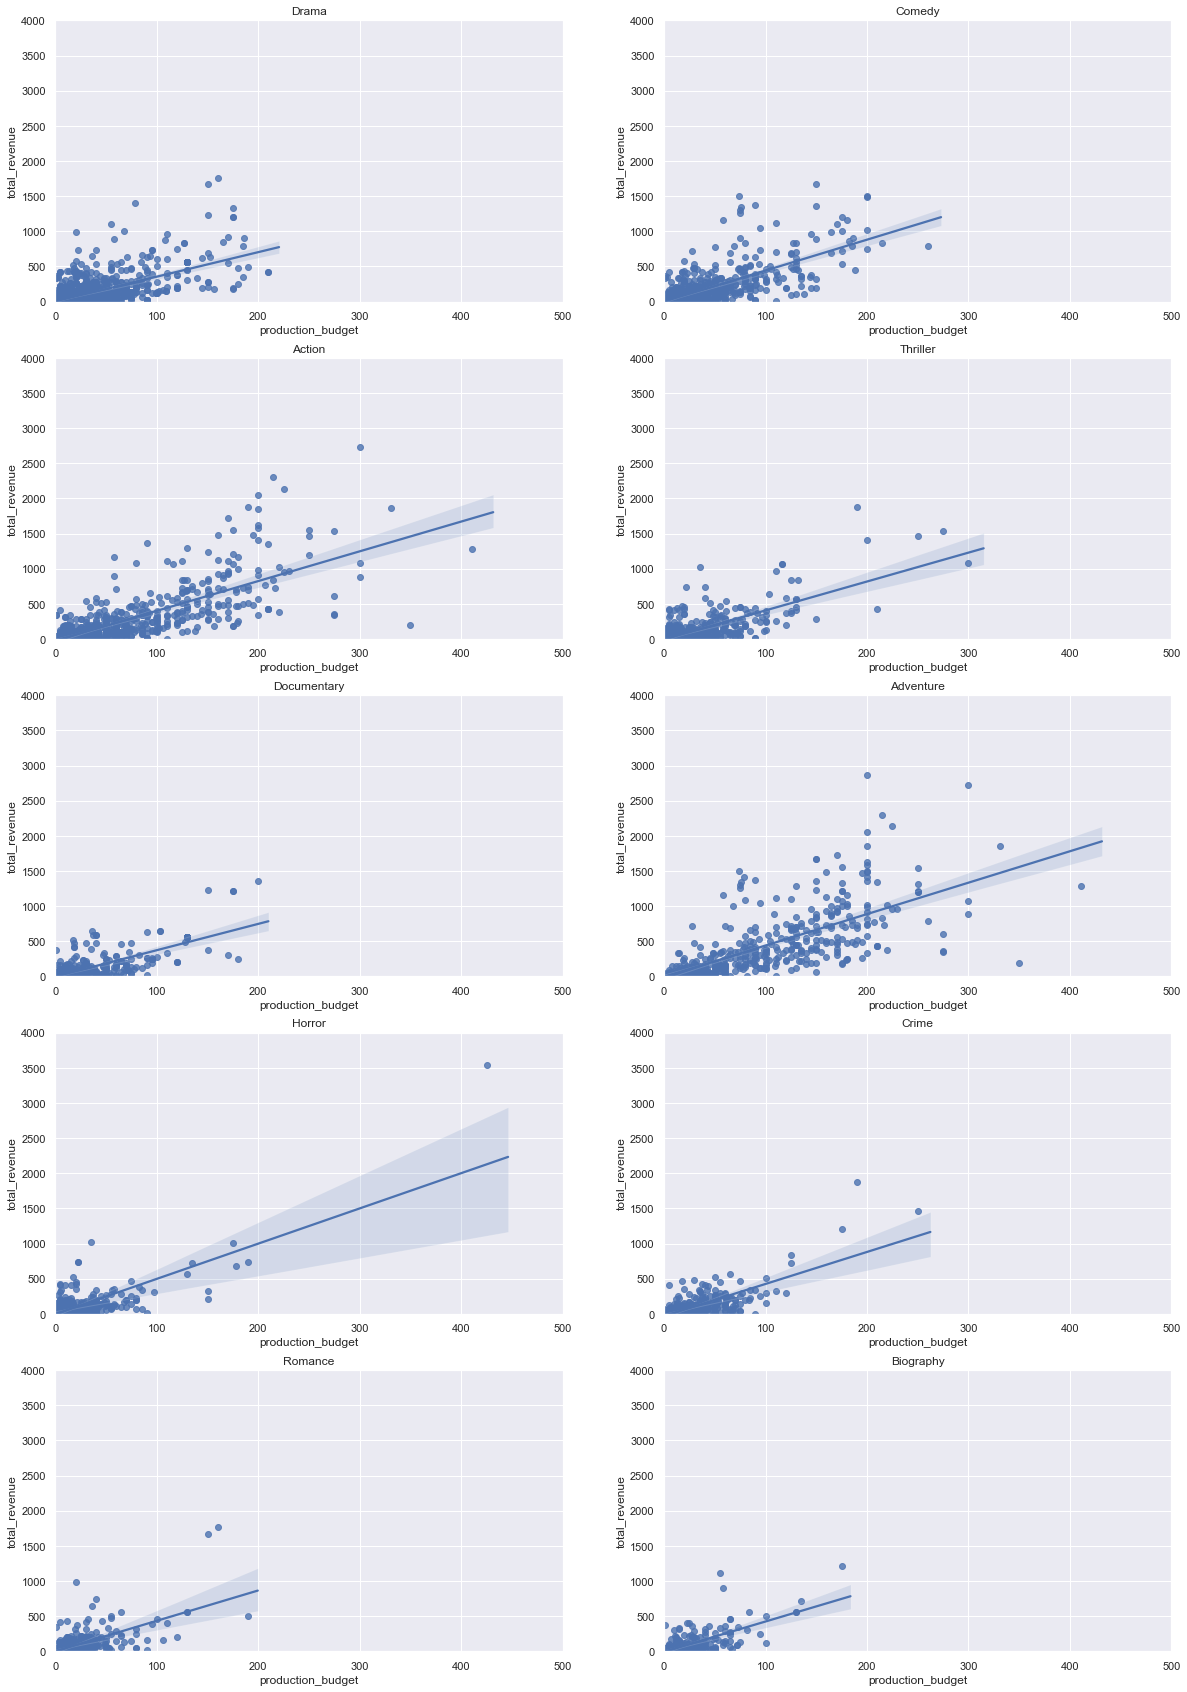

In [12]:
# Using for-loop to create regression plots and calcurate correlation coeffiient for each of the top ten genres.

coefficients = []
slopes = []
fig = plt.figure(figsize=(20,30))

for number, genre in enumerate(topten_genres_separated):
    # filter by genre
    df_bygenre = df_new[df_new['genres'].str.contains(genre)]

    # create regplot using 
    ax = fig.add_subplot(5, 2, number+1)
    plt.title(genre)
    sns.regplot(data=df_bygenre, x='production_budget', y='total_revenue')
    
    ax.set_xlim([0, 500])
    ax.set_ylim([0, 4000])
    
    coefficient = np.corrcoef(df_bygenre['production_budget'], df_bygenre['total_revenue'])
    coefficients.append(round(coefficient[0, 1], 2))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_bygenre['production_budget'], df_bygenre['total_revenue'])
    slopes.append(round(slope, 2))


Text(0, 0.5, 'correlation coefficient of the estimate')

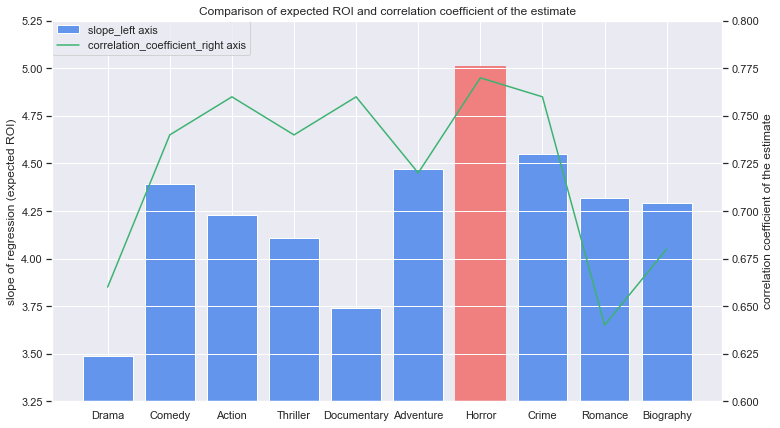

In [13]:
# visualization
plt.style.use('seaborn-pastel')

fig, ax1 = plt.subplots(figsize = (12,7))
ax2 = ax1.twinx()

bar = ax1.bar(topten_genres_separated, slopes, label='slope_left axis', color = 'cornflowerblue')
plot = ax2.plot(topten_genres_separated, coefficients, label='correlation_coefficient_right axis', color = 'mediumseagreen')
bar[6].set_color('lightcoral')

# setting legends
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

# setting limits on y-axis
ax1.set_ylim([3.25, 5.25])
ax2.set_ylim([0.6, 0.8])

# setting titles and axis labels
ax1.set_title('Comparison of expected ROI and correlation coefficient of the estimate')
ax1.set_ylabel('slope of regression (expected ROI)')
ax2.set_ylabel('correlation coefficient of the estimate')

By comparing the slope of regression lines above, "Horror" is the genre with the highest expected ROI (5.0). As a new entrant to the movie market, it is important for Microsoft to choose the most capital efficient genres initially.

*In the analysis above, we decided to divide the genres that covers multiple genres (for example, "Adventure, Animation, Comedy") into each genre ("Adventure", "Animation", "Comedy") and took such movies into consideration in each of the genres.

## Calcurating the recent trend of ROI of Horror movie

Below code is calcurating the recent trend of ROI of Horror movie. As the graph shows, the ROI of Horror movie is on the increase, potentially reflecting recent preference of consumers. 

C:\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

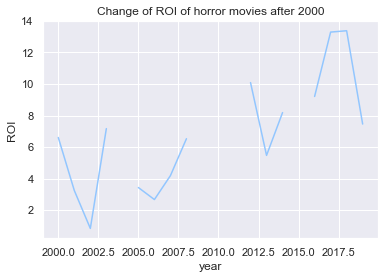

In [14]:
# Keep only the rows that includes 'Horror' in genres column
df_new_horror = df_new[df_new['genres'].str.contains('Horror')]

# Creating new columns that shows release year
df_new_horror['release_date'] = pd.to_datetime(df_new_horror['release_date'])
df_new_horror['year'] = df_new_horror['release_date'].map(lambda x: x.year)

# calcurate ROI
df_new_horror['ROI'] = df_new_horror['total_revenue'] / df_new_horror['production_budget']

# group by 'year' and calcurate mean of ROI in each year
df_new_horror_ROI = pd.DataFrame(df_new_horror.groupby('year').mean()['ROI'])

# only show years after 2000
df_new_horror_ROI = df_new_horror_ROI.reset_index()
df_new_horror_ROI_after = df_new_horror_ROI[df_new_horror_ROI['year']>= 2000]

# create lineplot
plt.title('Change of ROI of horror movies after 2000')
sns.lineplot(data=df_new_horror_ROI_after, x='year', y='ROI')


# What is the size of required budget and expected revenue?

As Microsoft considers entry of Horror movie market, one of the most important questions that the management of Microsoft should answer is the required budget size and expected (or target) revenue. Using the data we used to answer the previous question, we created whisker plot to visualize the estimate.

Based on the whisker plots below, 75% of horror movie had budget less than 25MM and only achieved 100MM for the revenue. However, Microsoft has much resources compared with existing players in the market, therefore, Microsoft should aim higher than 75 percentile figure. Speficically, they should spend 25MM-50MM and aim to achieve 300MM+ in revenue.

*whisker plots below is only showing values close to center for readability, but all analysis includes outliers that had huge budget and and revenue. This is because Microsoft is a company with a lot of resouces and may spend large budget to aim huge revenue, therefore, those that had significant size of budget are not considered as "outliers" for Microsoft. 

C:\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 600)

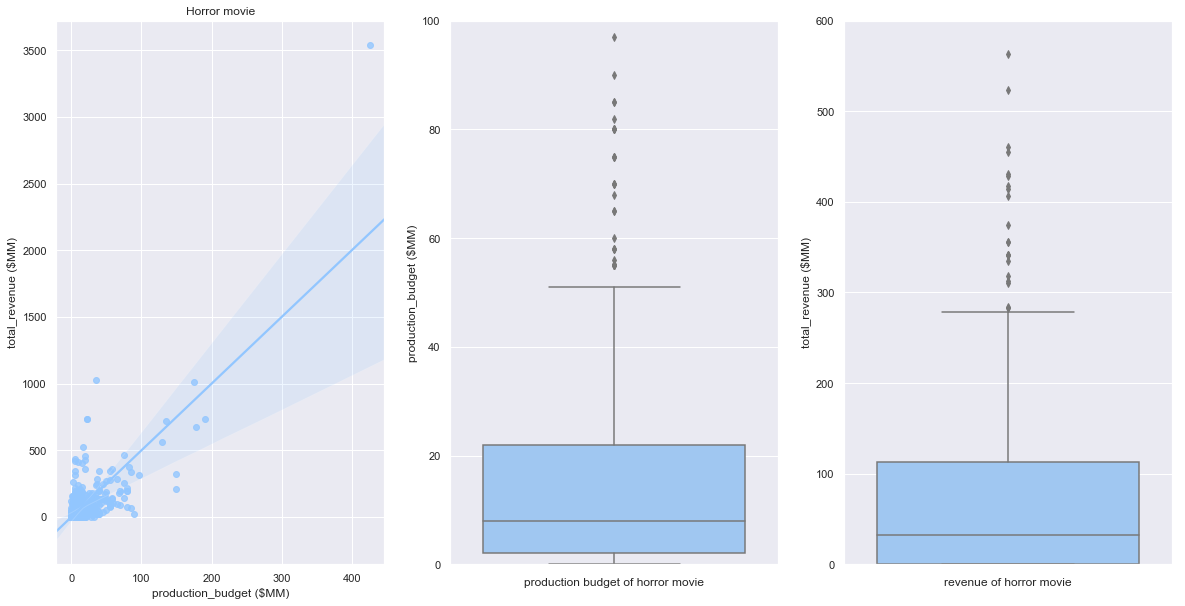

In [15]:
# filter by genre
df_bygenre_horror = df_new[df_new['genres'].str.contains('Horror')]

# create visualization
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 3, 1)

# create regplot
plt.title('Horror movie')
sns.regplot(data=df_bygenre_horror, x='production_budget', y='total_revenue')
plt.xlabel('production_budget ($MM)')
plt.ylabel('total_revenue ($MM)')

# create box plot
ax2 = fig.add_subplot(1, 3, 2)
sns.boxplot(data=df_bygenre_horror, y='production_budget')
plt.xlabel('production budget of horror movie')
plt.ylabel('production_budget ($MM)')

ax3 = fig.add_subplot(1, 3, 3)
sns.boxplot(data=df_bygenre_horror, y='total_revenue')
plt.xlabel('revenue of horror movie')
plt.ylabel('total_revenue ($MM)')

# setting limit on y-axis
ax2.set_ylim([0, 100])
ax3.set_ylim([0, 600])


# Who should be the director of the movie to maximize gross revenue and rating?

In order to find the perfect cast for our horror movie, we will select the movie director based to the gross revenue the horror movies achieved. 

1. Based on the analysis below, we should select a director from the top 10 directors who produced movies with highest average gross revenue. As there is no clear correlation between gross revenue and average rating, we will maximize revenue returns only.


2. In addition, we also found that R rated movies have slightly higher average box earnings, whereas PG-13 movies have a wider dispersion of box office earnings. We would recommend our director to direct a PG-13 movie given our expectation that the movie will be in the top quartile of box office performance.

In [6]:
# establish sql connection
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')
cursor = con.cursor()
# Pull IMBD data into a new df to get the title and the cast 
mov_df = pd.read_sql_query('''SELECT * FROM movies.imdb_title_basics 
                                JOIN movies.imdb_title_ratings USING (tconst)
                                INNER JOIN movies.imdb_title_principals USING (tconst)
                                JOIN movies.imdb_name_basics USING (nconst)
                                JOIN movies.bom_movie_gross
                                ON movies.imdb_title_basics.original_title = movies.bom_movie_gross.title
                                ;''', con)

# Data cleaning to find the subset of movie cast under horror genre

In [8]:
# Filter data according to include only horror movies
mov_df['horror_bool'] = mov_df.genres.str.contains("Horror")
horror_mov = mov_df.loc[mov_df['horror_bool'] == True]

horror_mov

,nconst,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,ordering,...,birth_year,death_year,primary_profession,known_for_titles,title,studio,domestic_gross,foreign_gross,year,horror_bool
200,nm0474709,tt1220634,Resident Evil: Afterlife,Resident Evil: Afterlife,2010,96.0,"Action,Adventure,Horror",5.9,153270,10,...,NaN,NaN,"producer,writer,camera_department","tt1502712,tt1188729,tt1220634,tt1855325",Resident Evil: Afterlife,SGem,60100000.0,240100000.0,2010,True
201,nm0000170,tt1220634,Resident Evil: Afterlife,Resident Evil: Afterlife,2010,96.0,"Action,Adventure,Horror",5.9,153270,1,...,1975.0,NaN,"actress,soundtrack,producer","tt1220198,tt1220634,tt0119116,tt0432021",Resident Evil: Afterlife,SGem,60100000.0,240100000.0,2010,True
202,nm0005123,tt1220634,Resident Evil: Afterlife,Resident Evil: Afterlife,2010,96.0,"Action,Adventure,Horror",5.9,153270,2,...,1976.0,NaN,"actress,music_department,producer","tt0250494,tt1220634,tt0195714,tt1198138",Resident Evil: Afterlife,SGem,60100000.0,240100000.0,2010,True
203,nm0589505,tt1220634,Resident Evil: Afterlife,Resident Evil: Afterlife,2010,96.0,"Action,Adventure,Horror",5.9,153270,3,...,1972.0,NaN,"actor,producer,writer","tt1220634,tt0308383,tt0455275,tt1682180",Resident Evil: Afterlife,SGem,60100000.0,240100000.0,2010,True
204,nm0167649,tt1220634,Resident Evil: Afterlife,Resident Evil: Afterlife,2010,96.0,"Action,Adventure,Horror",5.9,153270,4,...,1958.0,NaN,"actor,producer","tt0398712,tt1456635,tt0185183,tt1220634",Resident Evil: Afterlife,SGem,60100000.0,240100000.0,2010,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24805,nm2536997,tt7690762,The Pact,El pacto,2018,106.0,"Horror,Thriller",5.3,750,5,...,1982.0,NaN,"director,writer,assistant_director","tt1382727,tt2436672,tt1754045,tt5396928",El Pacto,Sony,2500.0,NaN,2018,True
24806,nm2553218,tt7690762,The Pact,El pacto,2018,106.0,"Horror,Thriller",5.3,750,6,...,NaN,NaN,writer,"tt5101192,tt10377170,tt6189268,tt3351126",El Pacto,Sony,2500.0,NaN,2018,True
24807,nm7864046,tt7690762,The Pact,El pacto,2018,106.0,"Horror,Thriller",5.3,750,7,...,NaN,NaN,producer,"tt3165636,tt5614612,tt6058136,tt4110388",El Pacto,Sony,2500.0,NaN,2018,True
24808,nm0309027,tt7690762,The Pact,El pacto,2018,106.0,"Horror,Thriller",5.3,750,8,...,1966.0,NaN,"writer,producer,miscellaneous","tt1764625,tt1444680,tt3896100,tt1186357",El Pacto,Sony,2500.0,NaN,2018,True


Since we want to hire the cast, we will remove the rows without birth_year and death_year data to retain only people who are currently alive.

In [32]:
#clean dataframe to exclude NaN entries for birth_year, and calculate age
horror_mov.dropna(subset=['birth_year'], inplace = True)
horror_mov['death_year'] = horror_mov['death_year'].replace(np.nan, 0)
horror_mov['total_gross'] = horror_mov['domestic_gross']+ horror_mov['foreign_gross']
horror_mov['crew_age'] = 2020 - horror_mov['birth_year']

C:\Users\Lingxi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Lingxi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lingxi\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

# Top 10 directors with the highest average movie total gross revenue

In [38]:
# Find the directors for the top grossing horror movie from 2010- 2020
director_rating = horror_mov[(horror_mov['category'] == 'director') & (horror_mov['death_year'] == 0) & (horror_mov['start_year'] > 2010) & (movie_names['numvotes'] > 8000)]. sort_values(by ='total_gross', ascending=False)
director_rating = director_rating.loc[:,['primary_title','primary_name','total_gross','crew_age','averagerating']]
director_gross = director_rating.groupby('primary_name').mean().sort_values(by ='total_gross', ascending=False)
director_gross.iloc[0:10]

C:\Users\Lingxi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,total_gross,crew_age,averagerating
primary_name,,,
Marc Forster,540000000.0,51.0,7.00
Jon Turteltaub,530200000.0,57.0,5.70
Corin Hardy,365600000.0,45.0,5.55
James Wan,319950000.0,43.0,7.45
Paul W.S. Anderson,276100000.0,55.0,5.50
Jordan Peele,255400000.0,41.0,7.70
Tim Burton,245500000.0,62.0,6.20
Ridley Scott,240900000.0,83.0,6.40
M. Night Shyamalan,188450000.0,50.0,6.75


# Relationship between gross revenue, age and average rating of horror movie directors

Based on the top grossing directors, we also need to explore if there is any relationship between the 3 factors for the following reasons:

  1) Average rating does not seem to have any bearing on total gross revenue, we need to confirm this observation
  
  2) It looks like most of the top directors are now in the older age bracket, we want to ensure that older age will not affect the director's abiliy to produce top grossing films

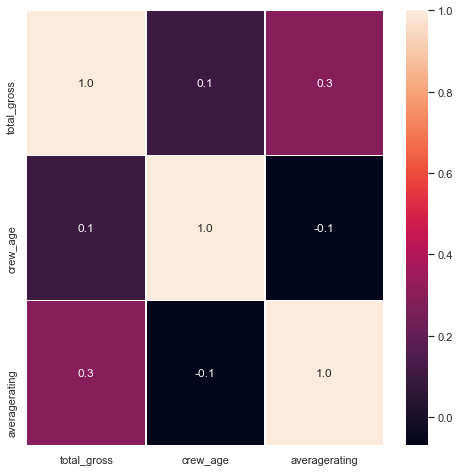

In [37]:
#check for relationship using a corr plot

correlation = director_gross
# correlation map
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(correlation.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In conclusion, there is only very weak correlation between total gross revenue and director's age, as well as between average rating and total gross revenue. We should focus on maxmizing our gross revenue.

# Rating for horror movie

In addition, we also want to know what is the rating we should ask our director to produce to maximize revenue. The rotten tomato database provides rating and box_office data to be analyzed

In [74]:
#initialize query and load dataframe
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')
cursor = con.cursor()

# # Pull IMBD data into df
mov_rt_df = pd.read_sql_query('''SELECT * FROM movies.rt_movie_info 
                                
                                ;''', con)

In [75]:
#clean up box_office columns as they are all in strings

mov_rt_df['box_office'] = mov_rt_df['box_office'].str.replace(',', '')
mov_rt_df['box_office'] = pd.to_numeric(mov_rt_df['box_office'])
mov_rt_df['box_office'].unique()

mov_rt_df['runtime'] = mov_rt_df['runtime'].str.replace('minutes', '')
mov_rt_df['runtime'] = pd.to_numeric(mov_rt_df['runtime'])

mov_rt_df['rating'] = mov_rt_df['rating'].astype('category')


In [71]:
mov_rt_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",,NaN,104.0,None
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108.0,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",,NaN,116.0,None
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",,NaN,128.0,None
4,7,,NR,Drama|Romance,Rodney Bennett,Giles Cooper,,,,NaN,200.0,None


In [76]:
# Remove NaN values from box office
mov_rt_df = mov_rt_df.dropna(subset = ['box_office'])

In [84]:
#identify all movies that contain horror
mov_rt_df['horror_bool'] = mov_rt_df.genre.str.contains("Horror")
horror_mov = mov_rt_df.loc[mov_rt_df['horror_bool'] == True]

In [86]:
# clean the data to include only box office
horror_rating_box = horror_mov.loc[:,['rating','box_office']]
horror_rating_box.set_index('rating')

,box_office
rating,
R,54100000.0
R,13248477.0
R,19755422.0
PG-13,128579698.0
R,84293.0
R,12583510.0
R,25957696.0
R,46982632.0
PG-13,10500000.0


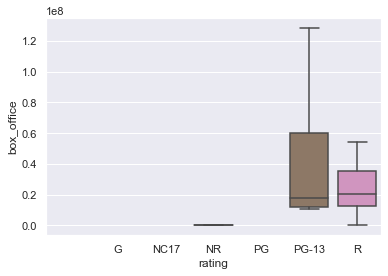

In [82]:
#plot box plot to see the distribution of box office earnings
sns.boxplot(x = 'rating', y = 'box_office', data=horror_rating_box)